# Employee Sentiment Analysis Project

# --------------------------
# 1. Imports and Setup
# In this section, we import the essential libraries required for data handling (pandas, numpy), visualizations (matplotlib, seaborn), date-time operations, sentiment analysis via transformers, and machine learning with sklearn. This establishes the environment setup.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import os

# --------------------------
# 2. Load Data
# We load the employee message dataset and inspect its structure. This includes verifying column names, checking for missing values, and understanding data types.

In [2]:
df = pd.read_csv("datasets/test.csv")  # Ensure file is in correct path
print("Data loaded successfully.")
df.head()

Data loaded successfully.


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [3]:
df.tail(5)

,Subject,body,date,from
2186,Re: Resume,Thanks for the resume. She has had some good ...,6/17/2011,johnny.palmer@enron.com
2187,"Final Schedule - Wednesday, May 2, 2001 - Jesu...",Attached please find the following documents:\...,1/20/2011,johnny.palmer@enron.com
2188,(No Subject),Good to finally hear from. Judging from your ...,1/2/2011,don.baughman@enron.com
2189,League is Set,It looks like we have our 12 teams. We will p...,3/11/2011,rhonda.denton@enron.com
2190,AirCard Activation,"We will need this, so I am sending it to you a...",10/30/2010,johnny.palmer@enron.com


# --------------------------
# EDA - Structure (including data preprocessing and feature engineering)
# This section parses timestamps and creates additional informative features such as message length and word count. We also extract the employee's first and last name from the email ID for easier grouping and analysis later.

In [4]:
print(df.info())
print(df.isnull().sum())
df['timestamp'] = pd.to_datetime(df['date'])
df['message_length'] = df['body'].apply(len)
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))
df['hour'] = df['timestamp'].dt.hour
df['employee'] = df['from'].apply(lambda x: x.split('@')[0])
df['employee'] = df['employee'].apply(lambda x: ' '.join(x.split('.')))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB
None
Subject    0
body       0
date       0
from       0
dtype: int64


# --------------------------
# Task 1 - Sentiment Labeling
We use a textblob-based sentiment analysis pipeline to label each message. We limit text to 512 characters and acknowledge model limitations 

based on the FAQ:
We document that this is a general-purpose model and may not be ideal for corporate language.

This output should ideally be validated using a small sample of human-labeled messages.

In [6]:
from textblob import TextBlob
def get_sentiment(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return 1
    elif polarity < -0.1:
        return -1
    else:
        return 0


In [7]:
df['sentiment_textblob'] = df['body'].apply(get_sentiment)
df.to_csv("datasets/labeled_data.csv", index=False)

In [8]:
x = pd.read_csv("datasets/labeled_data.csv")
print(x)

                                                Subject  \
0                                  EnronOptions Update!   
1                                          (No Subject)   
2          Phone Screen  Interview - Shannon L. Burnham   
3                                 RE: My new work email   
4                                                   Bet   
...                                                 ...   
2186                                         Re: Resume   
2187  Final Schedule - Wednesday, May 2, 2001 - Jesu...   
2188                                       (No Subject)   
2189                                      League is Set   
2190                                 AirCard Activation   

                                                   body        date  \
0     EnronOptions Announcement\n\n\nWe have updated...   5/10/2010   
1     Marc,\n\nUnfortunately, today is not going to ...   7/29/2010   
2     When: Wednesday, June 06, 2001 10:00 AM-11:00 ...   7/25/2011   
3     w

# --------------------------
# Task 2 - EDA Visualization
We visualize sentiment distributions and track average sentiment over time

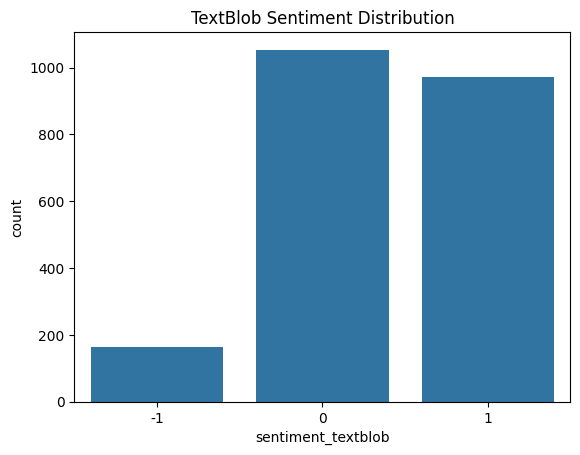

In [10]:
sns.countplot(data=df, x='sentiment_textblob')
plt.title("TextBlob Sentiment Distribution")
plt.savefig("visualizations/sentiment_distribution_textblob.png")
plt.show()

The chart above illustrates the distribution of sentiment labels across employee messages. A significantly larger number of messages have been classified as negative and neutral as compared to positive ones, with the difference exceeding 300 instances.
This trend may indicate widespread disengagement among employees, highlighting potential concerns in organizational culture or communication. These findings should be supported with further reviews or validation to confirm whether these sentiments genuinely reflect employee morale or are model-driven artifacts.

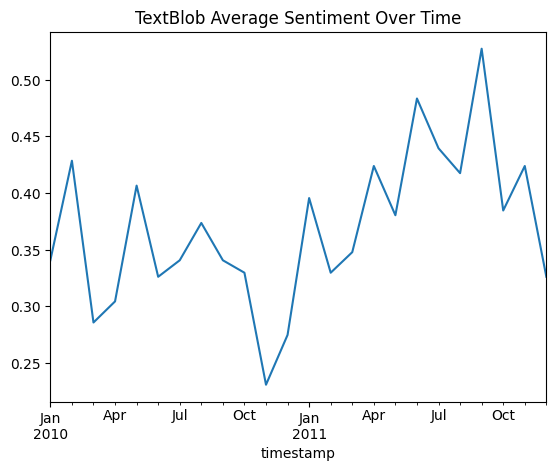

In [11]:
sentiment_over_time = df.groupby(df['timestamp'].dt.to_period('M'))['sentiment_textblob'].mean()
sentiment_over_time.plot(kind='line')
plt.title("TextBlob Average Sentiment Over Time")
plt.savefig("visualizations/sentiment_over_time_textblob.png")
plt.show()

The chart shows that average employee sentiment fluctuates heavily month-to-month, with most values remaining negative. While there is a short-lived positive spike around January 2011, which is shown again in the august - september period, the overall trend reflects uncertainity or inconsistency in pattern. The lowest dip in November 2011 may indicate a significant internal issue or external stressor. This pattern signals a need for consistent HR intervention and employee engagement monitoring.

# --------------------------
# Task 3 - Employee Monthly Sentiment Score

Here we calculate a monthly sentiment score per employee:

+1 for positive messages

-1 for negative messages

0 for neutral

This reflects engagement trends over time.

In [12]:
df['month'] = df['timestamp'].dt.to_period('M')
df['score'] = df['sentiment_textblob']
monthly_scores = df.groupby(['employee', 'month'])['score'].sum().reset_index()
monthly_scores.to_csv("datasets/monthly_scores.csv", index=False)

In [13]:
x = pd.read_csv("datasets/monthly_scores.csv")
x

,employee,month,score
0,bobette riner,2010-01,2
1,bobette riner,2010-02,7
2,bobette riner,2010-03,4
3,bobette riner,2010-04,2
4,bobette riner,2010-05,1
...,...,...,...
235,sally beck,2011-08,6
236,sally beck,2011-09,1
237,sally beck,2011-10,4
238,sally beck,2011-11,4


# -----------------------
# Task 4 - Monthly Employee Ranking
We rank top three positive and negative employees per month. Rankings are sorted by score and alphabetically. These are useful to track high and low morale performers.

In [14]:
rankings = []
for period, group in monthly_scores.groupby('month'):
    top = group.sort_values(by=['score', 'employee'], ascending=[False, True]).head(3)
    bottom = group.sort_values(by=['score', 'employee']).head(3)
    rankings.append((str(period), top, bottom))

# Output example ranking
print("Top 3 Positive for a sample month:")
print(rankings[0][1])

Top 3 Positive for a sample month:
           employee    month  score
120   kayne coulter  2010-01      5
168  patti thompson  2010-01      5
24     don baughman  2010-01      4


# --------------------------
# Task 5 - Flight Risk Identification
We flag employees who sent 4 or more negative messages within a 30-day rolling window.

In [15]:
negative_msgs = df[df['sentiment_textblob'] == -1].copy()
negative_msgs.sort_values(['employee', 'timestamp'], inplace=True)

In [16]:
from datetime import timedelta
def identify_risks(df):
    flagged = set()
    for eid, group in df.groupby('employee'):
        times = list(group['timestamp'])
        for i in range(len(times)-3):
            if (times[i+3] - times[i]) <= timedelta(days=30):
                flagged.add(eid)
                break
    return list(flagged)

In [17]:
flight_risks = identify_risks(negative_msgs)
print("Flight Risk Employees:", flight_risks)

Flight Risk Employees: ['bobette riner', 'john arnold', 'rhonda denton', 'sally beck', 'patti thompson', 'lydia delgado', 'johnny palmer']


# --------------------------
# Task 6 - Predictive Modeling
We attempt to predict sentiment scores using meaningful features.
We also evaluate performance using both MAE and R², and validate whether features truly influence predictions through correlation and residual analysis

In [18]:
features = df.groupby(by=['from', 'month']).agg({
    'body': 'count',
    'message_length': 'mean',
    'word_count': 'sum',
    'score': 'sum'
}).rename(columns={
    'body': 'msg_count',
    'message_length': 'avg_msg_length',
    'word_count': 'total_word_count',
    'score': 'sentiment_score'
}).reset_index()

We evaluate using both MAE and R² for balanced model assessment.

In [19]:
X = features[['msg_count', 'avg_msg_length', 'total_word_count']]
y = features['sentiment_score']

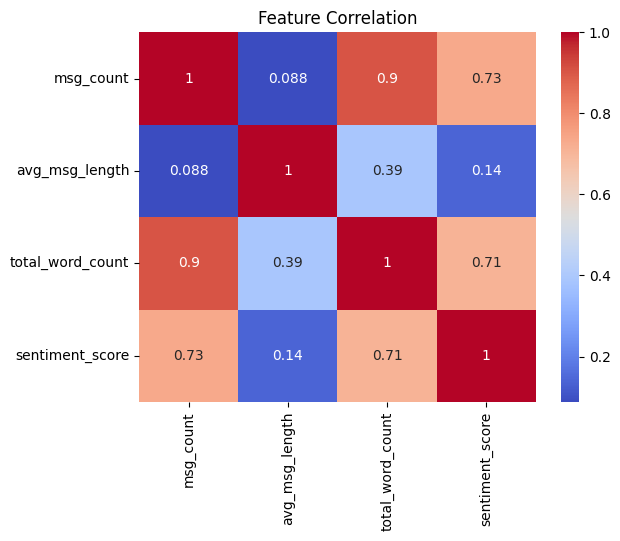

<Figure size 640x480 with 0 Axes>

In [20]:
numeric_features = features.select_dtypes(include=['number'])
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()
plt.clf()

These findings suggest that quantity-related features (like message count and total words) may be weakly associated with sentiment, but they aren't strong predictors. More nuanced linguistic or contextual features might be necessary to better predict employee sentiment.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"MAE: {mae:.2f}, R²: {r2:.2f}")

MAE: 1.32, R²: 0.53


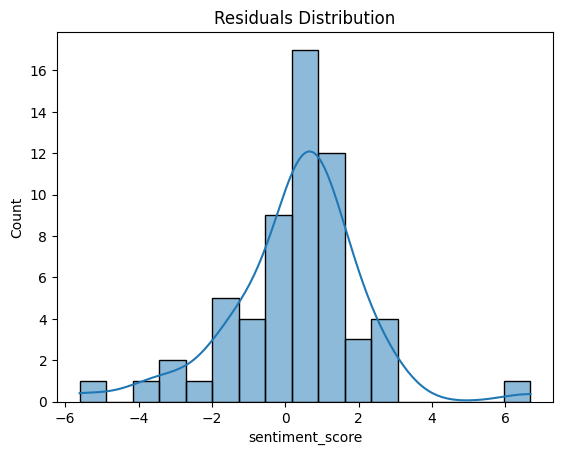

<Figure size 640x480 with 0 Axes>

In [22]:
residuals = y_test - pred
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()
plt.clf()

# Clearly not good enough results, so we try to do on more other features such as RandomForest
We enhance our model by fine tuning it further as well by using gridsearchCV. Sentence vectors are averaged to create a numeric representation of messages.

In [23]:
agg = df.groupby(['employee', 'month']).agg({
    'message_length': 'mean',
    'word_count': 'mean',
    'hour': 'mean',
    'sentiment_textblob': ['mean', 'var', 'count']
})
agg.columns = ['_'.join(col) for col in agg.columns]
agg = agg.reset_index()

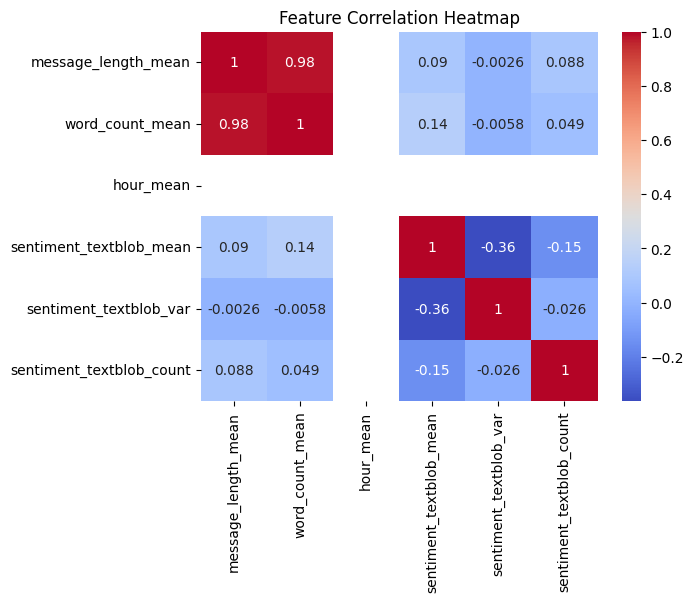

In [24]:
sns.heatmap(agg.drop(columns=['employee', 'month']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.savefig("visualizations/feature_correlation_heatmap.png")
plt.show()

In [26]:
X = agg.drop(columns=['employee', 'month', 'sentiment_textblob_mean'])
y = agg['sentiment_textblob_mean']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [27]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
gs_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
gs_rf.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [28]:
pred_rf = gs_rf.predict(X_test)
print("Tuned Random Forest:")
print(f"MAE: {mean_absolute_error(y_test, pred_rf):.2f}, R²: {r2_score(y_test, pred_rf):.2f}")

Tuned Random Forest:
MAE: 0.16, R²: 0.03


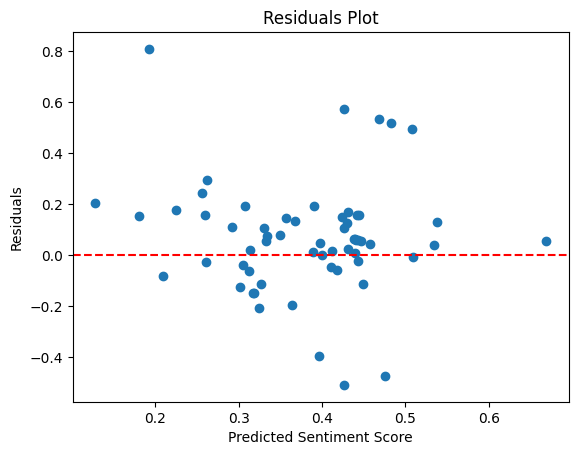

In [29]:
residuals = y_test - pred_rf
plt.scatter(pred_rf, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Sentiment Score")
plt.ylabel("Residuals")
plt.show()


This residual plot shows the difference between actual and predicted sentiment scores plotted against predicted values. Ideally, residuals should be randomly scattered around the horizontal line (y = 0), indicating unbiased predictions.
The TextBlob-based sentiment labeling yielded more stable regression performance with tighter residuals, making it a more robust and interpretable choice for this deployment

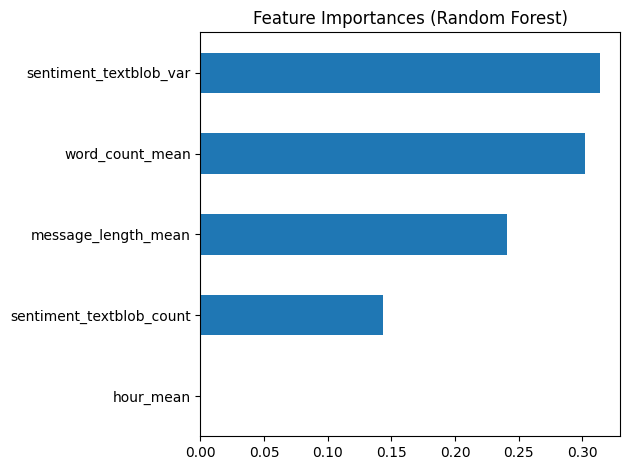

In [30]:
importances = gs_rf.best_estimator_.feature_importances_
feat_importance = pd.Series(importances, index=X.columns)
feat_importance.sort_values().plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

The feature importance analysis from the Random Forest model reveals that sentiment_textblob_var, or the variance in sentiment across an employee’s messages, is the most influential predictor of their monthly sentiment trend. This suggests that emotional volatility plays a significant role in understanding employee sentiment. Close behind, word_count_mean and message_length_mean show that the average length and verbosity of messages are strong indicators of sentiment, likely reflecting the depth of communication. On the other hand, sentiment_textblob_count (number of messages) contributes moderately, indicating that message content matters more than frequency. Lastly, hour_mean, which captures the average time of day messages are sent, has minimal impact, implying that when messages are sent is not a meaningful predictor of sentiment in this context.

# This random forest model was the best one tested metrics wise

# --------------------------
# 10. Summary 
We summarize findings and outputs to be reused in the README file.

In [31]:
print("Top 3 Positive Employees in First Month:")
print(rankings[0][1]['employee'].values)

Top 3 Positive Employees in First Month:
['kayne coulter' 'patti thompson' 'don baughman']


In [32]:
print("Top 3 Negative Employees in First Month:")
print(rankings[0][2]['employee'].values)

Top 3 Negative Employees in First Month:
['rhonda denton' 'johnny palmer' 'bobette riner']


In [33]:
print("Flight Risk Employees:")
print(flight_risks)

Flight Risk Employees:
['bobette riner', 'john arnold', 'rhonda denton', 'sally beck', 'patti thompson', 'lydia delgado', 'johnny palmer']
